# Bayesian Regression With Latent Gaussian Sampler

In this example, we want to illustrate how to use the marginal sampler implementation [`mgrad_gaussian`](https://blackjax-devs.github.io/blackjax/mcmc.html#blackjax.mgrad_gaussian) of the article [Auxiliary gradient-based sampling algorithms](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/rssb.12269) {cite:p}`auxgradientalgo2018`. We do so by using the simulated data from the example [Gaussian Regression with the Elliptical Slice Sampler](https://blackjax-devs.github.io/blackjax/examples/GP_Elliauxgradientalgo2018pticalSliceSampler.html). Please also refer to the complementary example [Bayesian Logistic Regression With Latent Gaussian Sampler](https://blackjax-devs.github.io/blackjax/examples/LogisticRegressionWithLatentGaussianSampler.html).

## Sampler Overview

In section we give a brief overview of the idea behind this particular sampler. For more details please refer to the original paper [Auxiliary gradient-based sampling algorithms](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/rssb.12269) ([here](https://arxiv.org/abs/1610.09641) you can access the arXiv preprint).

### Motivation: Auxiliary Metropolis-Hastings samplers

Let us recall how to sample from a target density $\pi(\mathbf{x})$ using a Metropolis-Hasting sampler trough a *marginal scheme process*. The main idea is to have a mechanism that generate proposals $y$ which we then accept or reject according to a specific criterion. Concretely, suppose that we have an *auxiliary* scheme given by

1. Sample $\mathbf{u}|\mathbf{x} \sim \pi(\mathbf{u}|\mathbf{x}) = q(\mathbf{u}|\mathbf{x})$.
2. Generate proposal $\mathbf{y}|\mathbf{u}, \mathbf{x} \sim q(\mathbf{y}|\mathbf{x}, \mathbf{u})$
3. Compute the Metropolis-Hasting ratio

```{math}
\tilde{\varrho} = \frac{\pi(\mathbf{y}|\mathbf{u})q(\mathbf{x}|\mathbf{y}, \mathbf{u})}{\pi(\mathbf{x}|\mathbf{u})q(\mathbf{y}|\mathbf{x}, \mathbf{u})}
```

4. Accept proposal $y$ with probability $\min(1, \tilde{\varrho})$ and reject it otherwise.

This scheme targets the auxiliary distribution $\pi(\mathbf{x}, \mathbf{u}) = \pi(\mathbf{x}) q(\mathbf{u}|\mathbf{x})$ in two steps.

Now, suppose we can instead compute the *marginal* proposal distribution $q(\mathbf{y}|\mathbf{x}) = \int q(\mathbf{y}|\mathbf{x}, \mathbf{u}) q(\mathbf{u}|\mathbf{x}) \mathrm{d}u$ in closed form, then an alternative scheme is given by:

1. We draw a proposal $y \sim q(\mathbf{y}\mid\mathbf{x})$.
2. Then we compute the Metropolis-Hasting ratio

```{math}
\varrho = \frac{\pi(\mathbf{y})q(\mathbf{x}|\mathbf{y})}{\pi(\mathbf{x})q(\mathbf{y}|\mathbf{x})}
```

3. Accept proposal $y$ with probability $\min(1, \varrho)$ and reject it otherwise.

### Example: Auxiliary Metropolis-Adjusted Langevin Algorithm (MALA)

Let's consider the case of an auxiliary random walk proposal $q(\mathbf{u}|\mathbf{x}) = N(\mathbf{u}|\mathbf{x}, (\delta /2) \mathbf{I})$ for $\delta > 0$ as in [[Section 2.2]  Auxiliary gradient-based sampling algorithms](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/rssb.12269), it is shown that one can use a first order approximation to sample from the (intractable) $\pi(\mathbf{x}|\mathbf{u})$ density by choosing

```{math}
q(\mathbf{y}|\mathbf{u}, \mathbf{x}) \propto N(\mathbf{y}|\mathbf{u} + (\delta/2)\nabla \log \pi(\mathbf{x}), (\delta/2) I).
```

The resulting marginal sampler can be shown to correspond to the Metropolis-adjusted Langevin algorithm (MALA) with

```{math}
q(\mathbf{y}| \mathbf{x}) = N(\mathbf{y}|\mathbf{x} + (\delta/2)\nabla \log \pi(\mathbf{x}), \delta I).
```

### Latent Gaussian Models

A particular case of interest is the latent Gaussian model where the target density has the form

```{math}
\pi(\mathbf{x}) \propto \overbrace{\exp\{f(\mathbf{x})\}}^{\text{likelihood}} \underbrace{N(\mathbf{x}|\mathbf{0}, \mathbf{C})}_{\text{Gaussian Prior}}
```

In this case, instead of linearising the full log density $\log \pi(\mathbf{x})$, we can linearise $f$ only, which, when combined with a random walk proposal $N(\mathbf{u}|\mathbf{x}, (\delta /2) \mathbf{I})$, recovers to the following auxiliary proposal

```{math}
q(\mathbf{y}|\mathbf{x}, \mathbf{u}) \propto N\left(\mathbf{y}|\frac{2}{\delta} \mathbf{A}\left(\mathbf{u} + \frac{\delta}{2}\nabla f(\mathbf{x})\right), \mathbf{A}\right),
```

where $\mathbf{A} = \delta / 2(\mathbf{C} + (\delta / 2)\mathbf{I})^{-1}\mathbf{C}$. The corresponding marginal density is

```{math}
q(\mathbf{y}|\mathbf{x}) \propto N\left(\mathbf{y}|\frac{2}{\delta} \mathbf{A}\left(\mathbf{x} + \frac{\delta}{2}\nabla f(\mathbf{x})\right), \frac{2}{\delta}\mathbf{A}^2 + \mathbf{A}\right).
```

Sampling from $\pi(\mathbf{x}, \mathbf{u})$, and therefore from $\pi(\mathbf{x})$, is done via Hastings-within-Gibbs as above.

A crucial point of this algorithm is the fact that $\mathbf{A}$ can be precomputed and afterward modified cheaply when $\delta$ varies. This makes it easy to calibrate the step-size $\delta$ at low cost.

---

Now that we have a high-level understanding of the algorithm, let's see how to use it in `blackjax`.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrnd
import matplotlib.pyplot as plt
import numpy as np

from blackjax import mgrad_gaussian

We generate data through a squared exponential kernel as in the example [Gaussian Regression with the Elliptical Slice Sampler](https://blackjax-devs.github.io/blackjax/examples/GP_EllipticalSliceSampler.html).

In [2]:
def squared_exponential(x, y, length, scale):
    dot_diff = jnp.dot(x, x) + jnp.dot(y, y) - 2 * jnp.dot(x, y)
    return scale**2 * jnp.exp(-0.5 * dot_diff / length**2)

In [3]:
n, d = 2000, 2
length, scale = 1.0, 1.0
y_sd = 1.0

# fake data
rng = jrnd.PRNGKey(10)
kX, kf, ky = jrnd.split(rng, 3)

X = jrnd.uniform(kX, shape=(n, d))
Sigma = jax.vmap(
    lambda x: jax.vmap(lambda y: squared_exponential(x, y, length, scale))(X)
)(X) + 1e-3 * jnp.eye(n)
invSigma = jnp.linalg.inv(Sigma)
f = jrnd.multivariate_normal(kf, jnp.zeros(n), Sigma)
y = f + jrnd.normal(ky, shape=(n,)) * y_sd

# conjugate results
posterior_cov = jnp.linalg.inv(invSigma + 1 / y_sd**2 * jnp.eye(n))
posterior_mean = jnp.dot(posterior_cov, y) * 1 / y_sd**2

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Let's visualize the distribution of the vector `y`.

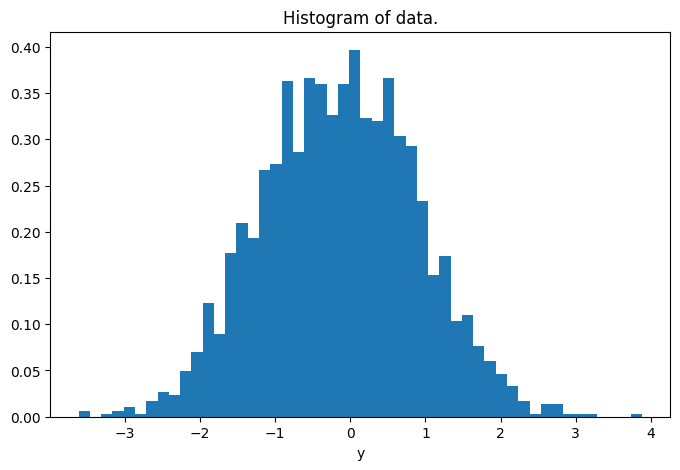

In [4]:
plt.figure(figsize=(8, 5))
plt.hist(np.array(y), bins=50, density=True)
plt.xlabel("y")
plt.title("Histogram of data.")
plt.show()

## Sampling

Now we proceed to run the sampler. First, we set the sampler parameters:

In [5]:
# sampling parameters
n_warm = 2000
n_iter = 500

Next, we define the the log-probability function. For this we need to set the log-likelihood function.

In [6]:
loglikelihood_fn = lambda f: -0.5 * jnp.dot(y - f, y - f) / y_sd**2
logdensity_fn = lambda f: loglikelihood_fn(f) - 0.5 * jnp.dot(f @ invSigma, f)

Now we are ready to initialize the sampler. The output is type is a `NamedTuple` with the following fields:

```
init:
    A pure function which when called with the initial position and the
    target density probability function will return the kernel's initial
    state.

step:
    A pure function that takes a rng key, a state and possibly some
    parameters and returns a new state and some information about the
    transition.
```

In [7]:
init, step = mgrad_gaussian(logdensity_fn=logdensity_fn, mean=jnp.zeros(n), covariance=Sigma)

We continue by setting the inference loop.

In [8]:
def inference_loop(rng, init_state, kernel, n_iter):
    keys = jrnd.split(rng, n_iter)

    def step(state, key):
        state, info = kernel(key, state)
        return state, (state, info)

    _, (states, info) = jax.lax.scan(step, init_state, keys)
    return states, info

We are now ready to run the sampler! The only extra parameters in the `step` function is `delta`, which (as seen in the sampler description) corresponds (in a loose sense) to the step-size of MALA algorithm.

``` {admonition} Adaptation
Note that one can calibrate the `delta` parameter as described in the example [Bayesian Logistic Regression With Latent Gaussian Sampler](https://blackjax-devs.github.io/blackjax/examples/LogisticRegressionWithLatentGaussianSampler.html).
```

In [9]:
%%time

kernel = lambda key, x: step(rng_key=key, state=x, delta=0.5)
initial_state = init(f)

states, info = inference_loop(jrnd.PRNGKey(0), init(f), kernel, n_warm + n_iter)
samples = states.position[n_warm:]

CPU times: user 16.9 s, sys: 188 ms, total: 17.1 s
Wall time: 17 s


## Diagnostics

Finally we evaluate the results.

In [10]:
error_mean = jnp.mean((samples.mean(axis=0) - posterior_mean) ** 2)
error_cov = jnp.mean((jnp.cov(samples, rowvar=False) - posterior_cov) ** 2)
print(
    f"Mean squared error for the mean vector {error_mean} and covariance matrix {error_cov}"
)

Mean squared error for the mean vector 0.001998048508539796 and covariance matrix 1.3341910971575999e-06


In [11]:
keys = jrnd.split(rng, 500)
predictive = jax.vmap(lambda k, f: f + jrnd.normal(k, (n,)) * y_sd)(
    keys, samples[-1000:]
)

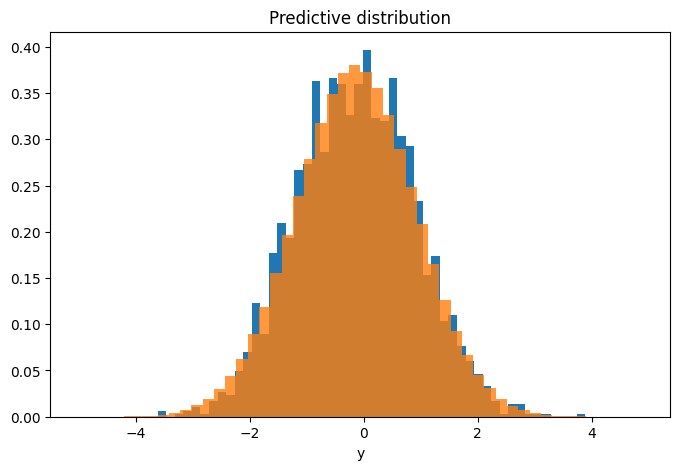

In [12]:
plt.figure(figsize=(8, 5))
plt.hist(np.array(y), bins=50, density=True)
plt.hist(np.array(predictive.reshape(-1)), bins=50, density=True, alpha=0.8)
plt.xlabel("y")
plt.title("Predictive distribution")
plt.show()

```{bibliography}
:filter: docname in docnames
```